In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

### Get Floating Car Tracks

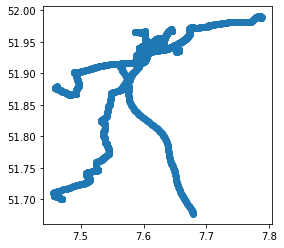

In [2]:
from shapely.geometry import *

bbox = BboxSelector([
    7.551165771484375, # min_x
    51.92807412325402, # min_y
    7.608200988769531, # max_x
    51.94261482608728  # max_y
])

# Requesting a single track
track_df = track_api.get_tracks(bbox=bbox, num_results=10)
track_df.plot()

### Load OSM graph

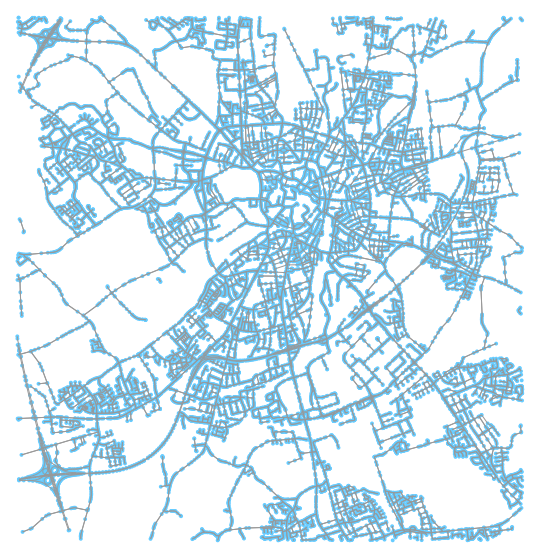

CPU times: user 10.3 s, sys: 575 ms, total: 10.9 s
Wall time: 12.3 s


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a30571250>)

In [3]:
%%time
import numpy as np
import osmnx as ox

lat = 51.950296032982756
lng = 7.615756988525391

# Get the OSM graph of "drive" streets for münster an plot it
graph = ox.graph.graph_from_bbox(51.9925, 
    51.9045, 
    7.6891, 
    7.551165771484375 , network_type='drive',simplify=False, retain_all=True)
#graph = ox.graph_from_point((lat, lng), dist=10000, network_type='drive')
ox.plot_graph(graph, fig_height=10, fig_width=10)

### Extract coordinates

CPU times: user 81.8 ms, sys: 4.84 ms, total: 86.6 ms
Wall time: 84.5 ms


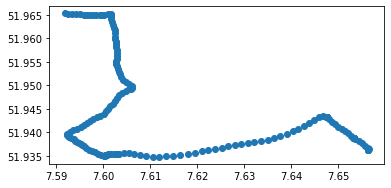

In [4]:
%%time
some_track_id = track_df['track.id'].unique()[2]
some_track = track_df[track_df['track.id'] == some_track_id]

# Get the latitude and longitude coordinates from the track and join them in an array
lats = list(some_track['geometry'].apply(lambda coord: coord.y))
lngs = list(some_track['geometry'].apply(lambda coord: coord.x))

track_coords = [c for c in zip(lats, lngs)]

some_track.plot()

### Mapmatching

In [5]:
import mapmatching as mm

edge_ids, last_idx, track_corr, route = mm.match(track_coords, graph)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
mm.plot_html(track_coords, track_corr=track_corr, route_corr=route,
          proj=True, show_graph=True)

### Processing

In [7]:
st_nodes = []
end_nodes = []
max_speed = []
for i in edge_ids[:last_idx + 1]:
    st_nodes.append(i[0])
    end_nodes.append(i[1])
    
    try:
        max_speed.append(float(graph.edges[(i[0],i[1],0)]['maxspeed']))
    except:
        max_speed.append(0)
    
some_track['st_nodes'] = st_nodes
some_track['end_nodes'] = end_nodes
some_track['max_speed'] = max_speed

track = pd.DataFrame({'st_node': some_track["st_nodes"], 'end_node': some_track["end_nodes"], 'speed':some_track["Speed.value"], 'time':some_track["time"], 'speed_limit': some_track["max_speed"], 'CO2':some_track["CO2.value"]})
edgeset = track

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

### Segment based speed aggregation

In [13]:
import aggregation as agr

edgeset = agr.aggregateStatsFromNodes(track,col = 'speed')
edgeset = agr.appendNodeCoords(edgeset)
speed = agr.plotAggregatedStatistics(edgeset,col = 'speed')
speed

### Segment based speed limits

In [14]:
edgeset = agr.aggregateStatsFromNodes(track,col = 'speed')
edgeset = agr.appendNodeCoords(edgeset)
edgeset["DiffBetweenSpeedLimit"] = edgeset['mean_speed'] - edgeset['speed_limit']
speedlimit = agr.plotAggregatedStatistics(edgeset,col = 'speedLimits')
speedlimit

### Segment based co2 emission aggregation

In [15]:
edgeset = agr.aggregateStatsFromNodes(track,col = 'co2')
edgeset = agr.appendNodeCoords(edgeset)
co2 = agr.plotAggregatedStatistics(edgeset,col = 'co2')
co2

### Segment based speed aggregation (Time Based)

In [17]:
concatTracks1  = track
hour = 0
day = 0
month = 0
to = 9
FilterTracks = agr.TimeBasedAggreagating(concatTracks1, hour, day,month,to)
concatAggregatedTracks = agr.aggregateStatsFromNodes(FilterTracks, col = 'speed')
contrack = agr.appendNodeCoords(concatAggregatedTracks)


In [18]:
timeBased = agr.plotAggregatedStatistics(contrack, col = 'speed')
timeBased